## Problem Statement
Retail sales are influenced by multiple factors, including seasonality, economic trends, and special events. Incorrect sales predictions can lead to stock shortages or overstocking, resulting in revenue loss and increased operational costs. The challenge is to develop a predictive model that accurately forecasts sales for the next 15 days, incorporating external variables to improve forecast reliability.

## Objective
The goal of this project is to analyze historical sales data, engineer meaningful features, and train multiple forecasting models to predict future sales. We will compare different approaches, evaluate model performance using error metrics, and extract business insights to aid decision-making in inventory management and sales optimization.

## Dataset

This dataset consists of multiple files that provide information on historical sales, store details, economic factors, and events that may influence demand. Below is a description of each file and its key fields.  

### **1. train.csv**  
Contains historical sales data, including product categories, promotions, and total sales.  
- **`date`** : Sale date  
- **`store_nbr`** : Unique store identifier where the product is sold  
- **`family`** : Product category  
- **`sales`** : Total sales for a product family at a particular store on a given date (fractional values are possible)  
- **`onpromotion`** : Count of items in a product family that were on promotion at a store on a given date  

### **2. test.csv**    
- **`date`** : Forecasting date (15 days after the last date in `train.csv`)  
- **`store_nbr`** : Store identifier  
- **`family`** : Product category  
- **`onpromotion`** : Count of promoted items for a product family at a store on a given date  

### **3. transactions.csv**  
Tracks the number of transactions per store on a daily basis, providing insights into customer activity.  
- **`date`** : Transaction date  
- **`store_nbr`** : Store identifier  
- **`transactions`** : Number of transactions recorded at the given store on the specified date  

### **4. stores.csv**  
Provides metadata about the stores, including location and segmentation.  
- **`store_nbr`** : Unique store identifier  
- **`city`** : Store location (city)  
- **`state`** : Store location (state)  
- **`type`** : Store category  
- **`cluster`** : Store grouping based on similarity  

### **5. oil.csv**  
Contains daily oil prices, which may impact the economy and consumer spending behavior.  
- **`date`** : Date of the recorded oil price  
- **`dcoilwtico`** : Daily WTI crude oil price (some values may be missing)  

### **6. holidays_events.csv**  
Lists holidays and special events that may affect sales, along with metadata on their significance.  
- **`date`** : Event date  
- **`type`** : Type of event (holiday, additional holiday, bridge, etc.)  
- **`locale`** : Scope of the event (national, regional, or local)  
- **`locale_name`** : Specific region or city affected  
- **`description`** : Brief event description  
- **`transferred`** : Boolean flag indicating if the holiday was rescheduled  


In [1]:
# Importing required packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing data using pandas
holidays_df = pd.read_csv(r"store_forecasting_data/holidays_events.csv")
oil_df = pd.read_csv(r"store_forecasting_data/oil.csv")
stores_df = pd.read_csv(r"store_forecasting_data/stores.csv")
transactions_df = pd.read_csv(r"store_forecasting_data/transactions.csv")
train_df = pd.read_csv(r"store_forecasting_data/train.csv")
test_df = pd.read_csv(r"store_forecasting_data/test.csv")

In [7]:
holidays_df.head(8)

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   
5  2012-05-12  Holiday     Local        Puyo         Cantonizacion del Puyo   
6  2012-06-23  Holiday     Local    Guaranda      Cantonizacion de Guaranda   
7  2012-06-25  Holiday  Regional    Imbabura  Provincializacion de Imbabura   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  
5        False  
6        False  
7        False

In [8]:
oil_df.head(8)

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20
5  2013-01-08       93.21
6  2013-01-09       93.08
7  2013-01-10       93.81

In [9]:
stores_df.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [10]:
transactions_df.head()

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

In [16]:
train_df.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

### Dataset Summary & Structure

In [81]:
df_dict = {'holidays_df':holidays_df,
           'oil_df':oil_df,
           'stores_df':stores_df,
           'transactions_df':transactions_df, 
           'train_df':train_df,
           'test_df':test_df
          }

In [86]:
for name, df in df_dict.items():
    print('*'*10 +' '+ name +' '+'*'*10 )
    print(df.info())
    print()

********** holidays_df **********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None

********** oil_df **********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None

********** stores_df **********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (tota

### Check for null values in each dataframe

In [82]:
for name, df in df_dict.items():
    print('*'*10 +' '+ name +' '+'*'*10 )
    print(df.isnull().sum())
    print()

********** holidays_df **********
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

********** oil_df **********
date           0
dcoilwtico    43
dtype: int64

********** stores_df **********
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

********** transactions_df **********
date            0
store_nbr       0
transactions    0
dtype: int64

********** train_df **********
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

********** test_df **********
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64



### Check for duplicated records in each dataframe

In [83]:
for name, df in df_dict.items():
    print('*'*10 +' '+ name +' '+'*'*10 )
    print(df.duplicated().sum())
    print()

********** holidays_df **********
0

********** oil_df **********
0

********** stores_df **********
0

********** transactions_df **********
0

********** train_df **********
0

********** test_df **********
0



## **Data Overview**  

- **holidays_df**: 350 rows, 6 columns (5 object, 1 boolean), no missing values, no duplicates  
- **oil_df**: 1,218 rows, 2 columns (1 object, 1 float64), missing values in `dcoilwtico`, no duplicates  
- **stores_df**: 54 rows, 5 columns (3 object, 2 int64), no missing values, no duplicates  
- **transactions_df**: 83,488 rows, 3 columns (1 object, 2 int64), no missing values, no duplicates  
- **train_df**: 3,000,888 rows, 6 columns (2 object, 3 int64, 1 float64), no missing values, no duplicates  
- **test_df**: 28,512 rows, 5 columns (2 object, 3 int64), no missing values, no duplicates  

## Data Cleaning

### **1. Merging Datasets**  
All datasets are merged into a single dataframe (`main_df`) using common keys such as `date`, `store_nbr`, and `family`. This ensures that all relevant information is available for analysis and modeling.  

**Note:** All transformations applied to `main_df` will also be performed on `test_df` to maintain consistency for model training and prediction.  

### **2. Checking for Duplicates**

### **3. Converting Date Column**  
- The `date` column should be converted from **object** to **datetime format** for proper time-based analysis and feature engineering. 

### **4. Handling Missing Values**  
- Missing values have to be checked and should be appropriately handled.

### **5. Removing Unnecessary Columns**  
- Columns that **not contributing to sales forecasting** are removed.    

   



#### 1. Merging datasets into one main dataset

In [3]:
# merging all dataframe into 1 dataframe
main_df = train_df.merge(stores_df, on='store_nbr', how='left')

main_df = main_df.merge(transactions_df, on=['date', 'store_nbr'], how='left')

main_df = main_df.merge(oil_df, on='date', how='left')

main_df = main_df.merge(holidays_df, on='date', how='left')

In [88]:
main_df.head()

id        date  store_nbr      family  sales  onpromotion   city  \
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0  Quito   
1   1  2013-01-01          1   BABY CARE    0.0            0  Quito   
2   2  2013-01-01          1      BEAUTY    0.0            0  Quito   
3   3  2013-01-01          1   BEVERAGES    0.0            0  Quito   
4   4  2013-01-01          1       BOOKS    0.0            0  Quito   

       state type_x  cluster  transactions  dcoilwtico   type_y    locale  \
0  Pichincha      D       13           NaN         NaN  Holiday  National   
1  Pichincha      D       13           NaN         NaN  Holiday  National   
2  Pichincha      D       13           NaN         NaN  Holiday  National   
3  Pichincha      D       13           NaN         NaN  Holiday  National   
4  Pichincha      D       13           NaN         NaN  Holiday  National   

  locale_name         description transferred  
0     Ecuador  Primer dia del ano       False  
1     Ecuador  Primer dia del ano       False  
2     Ecuador  Primer dia del ano       False  
3     Ecuador  Primer dia del ano       False  
4     Ecuador  Primer dia del ano       False

In [4]:
main_df = main_df.rename(columns = {"type_y" : "holiday_type", "type_x" : "store_type", "dcoilwtico": "oil_price"}) # replace columns names

In [95]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   int64  
 6   city          object 
 7   state         object 
 8   store_type    object 
 9   cluster       int64  
 10  transactions  float64
 11  oil_price     float64
 12  holiday_type  object 
 13  locale        object 
 14  locale_name   object 
 15  description   object 
 16  transferred   object 
dtypes: float64(3), int64(4), object(10)
memory usage: 396.1+ MB


#### 2. Checking for duplicate records

In [49]:
main_df.duplicated().sum()

0

**Observations:**
   * No duplicated records found

#### 3. Datatype conversion
The date column is in object datatype, let's convert it to proper datetime

In [5]:
# Converting the 'date' column to datetime format
main_df['date'] = pd.to_datetime(main_df['date'])

#### 4. Checking for null values

In [109]:
main_df.isnull().mean()*100

id               0.000000
date             0.000000
store_nbr        0.000000
family           0.000000
sales            0.000000
onpromotion      0.000000
city             0.000000
state            0.000000
store_type       0.000000
cluster          0.000000
transactions     8.156143
oil_price       31.271879
holiday_type    83.547258
locale          83.547258
locale_name     83.547258
description     83.547258
transferred     83.547258
dtype: float64

**Observations:**  

- A significant portion (**>80%**) of missing values was found in `holiday_type`, `locale`, `locale_name`, `description`, and `transferred`, making them unsuitable for imputation. 

    - **The `holiday_type` and `transferred` columns are essential for analyzing sales trends during special events.**  
    - Since missing values in `holiday_type` indicate **regular workdays**, it is reasonable to replace them with `"Work Day"` to maintain consistency.  
    - The `transferred` column indicates whether a holiday was rescheduled. Missing values mean **no holiday was transferred**, so replacing NaNs with `False` ensures accurate representation.  
   * The other columns will be **dropped** as they won't help us in the analysis.  
- The `transactions` column had **8% missing values**, which will be **filled using the store-wise median** to maintain historical transaction patterns without distorting trends.  
- The `oil_price` column had **32% missing values**, requiring careful handling. **Linear interpolation** was chosen as it effectively preserves the natural fluctuations of oil prices over time. 
    * We are using Interpolation technique to fill up these missing values
    * Since,Interpolation will not significantly distort trends.
    * Oil prices typically change gradually. Linear interpolation helps estimate missing values without introducing sudden jumps or biases.
    * Interpolation considers both previous and next values, making it a better choice for continuous data.
    We use linear interpolation to estimate missing values and ensure a smooth, continuous dataset.


**a. Replacing NaN values with work days in holiday_type and NaN in transferred columns to False**

In [6]:
main_df['holiday_type'].fillna("Work Day", inplace=True)
main_df['transferred'].fillna('False', inplace=True)

**b. Handling Missing Transactions Data**  

- The transaction counts vary widely, making **mode imputation unsuitable**, as it would replace missing values with a **single dominant value**, introducing bias.  
- **Mean imputation is not ideal** since it is affected by outliers, which could distort the actual transaction patterns.  
- The best approach is to **replace missing values with the median transactions of their respective stores**, making it more reliable.

In [7]:
main_df['transactions'].fillna(main_df.groupby('store_nbr')['transactions'].transform('median'), inplace=True)

#### c. **Handling Missing Values in Oil Prices**  

We are using Interpolation technique to fill up these missing values
   - Since, Interpolation will not significantly distort trends.  
   - Oil prices typically change gradually. Linear interpolation helps estimate missing values **without introducing sudden jumps** or biases.   
   - **Interpolation considers both previous and next values**, making it a better choice for continuous data.  

We use **linear interpolation** to estimate missing values and ensure a smooth, continuous dataset.  

In [84]:
oil_prices_df = main_df[['date','oil_price']].copy()

In [8]:
# Fill missing values in oil_price using linear interpolation
main_df['oil_price'].interpolate(method='linear', inplace = True)

#### **Validation**  
To verify the effectiveness of interpolation, we plot the oil price data before and after filling missing values

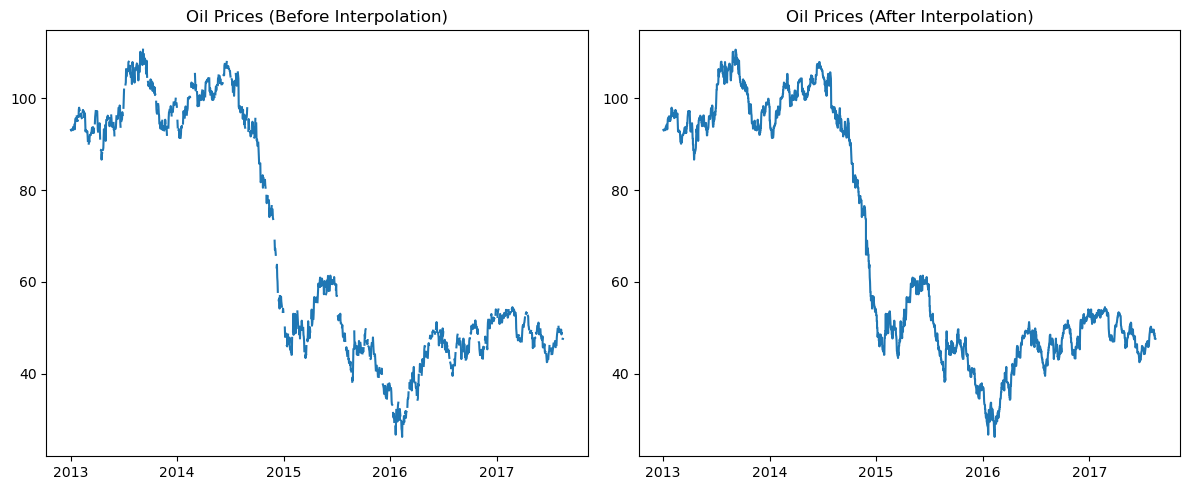

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot before interpolation (stored in oil_prices_df)
ax[0].plot(oil_prices_df['date'], oil_prices_df['oil_price'])
ax[0].set_title("Oil Prices (Before Interpolation)")

# Plot after interpolation
ax[1].plot(main_df['date'], main_df['oil_price'])
ax[1].set_title("Oil Prices (After Interpolation)")

plt.tight_layout()
plt.show()

**5. Dropping unnecessary columns**
* Since locale, locale_name, description have too many missing values **>80%** we chose to remove these columns along with id column that do not have any predictive capability

In [9]:
# dropping columns that have high number of missing values
# also removing id column since it doesn't have any predcitve capacity
main_df.drop(columns=['locale','locale_name','description','id'], inplace = True)
main_df.head(2)

date  store_nbr      family  sales  onpromotion   city      state  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   

  store_type  cluster  transactions  oil_price holiday_type transferred  
0          D       13        1746.0        NaN      Holiday       False  
1          D       13        1746.0        NaN      Holiday       False

## 2. Feature Engineering

**a. Time-based Features:**
  - Extract day, week, month, year, and day of the week.
  - Identify seasonal trends (e.g., are sales higher in December?).
  
**b. Event-based Features:**
  - Create binary flags for holidays, promotions, and economic events.
  - Identify if a day is a government payday (15th and last day of the month).
  - Consider earthquake impact (April 16, 2016) as a separate feature.
  
**c. Rolling Statistics:**
  - Compute moving averages and rolling standard deviations for past sales.
  - Include lagged features (e.g., sales from the previous week, previous month).
  
**d. Store-Specific Aggregations:**
  - Compute average sales per store type.
  - Identify top-selling product families per cluster

#### a. **Extracting Time-Based Features** - day, day_of_week, week, month, year

**These features help the model understand seasonal trends, weekly sales patterns, and long-term growth or decline in sales.**

In [10]:
main_df['day'] = main_df['date'].dt.day
main_df['week'] = main_df['date'].dt.isocalendar().week
main_df['month'] = main_df['date'].dt.month
main_df['year'] = main_df['date'].dt.year
main_df['day_of_week'] = main_df['date'].dt.weekday  # Monday=0, Sunday=6

#### Observing if there are any seasonal trends

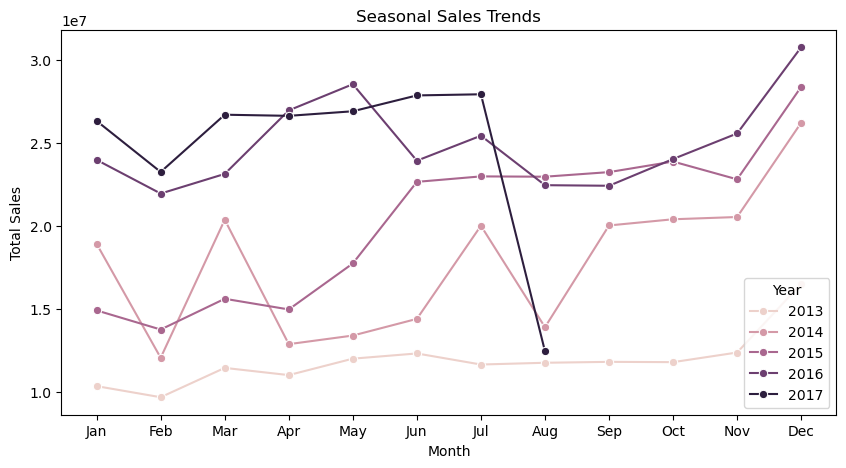

In [104]:
monthly_sales = main_df.groupby(['year', 'month'])['sales'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_sales, x='month', y='sales', hue='year', marker='o')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Seasonal Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Year')
plt.show()

### **Observations:**  
- Sales data from **2013 to 2017** shows a **consistent increase in December**, regardless of sales trends in other months.  
- This suggests a **strong seasonal effect** likely due to **holiday shopping, promotions, or year-end demand surges**.  
- Understanding this pattern can help in **inventory planning, targeted promotions, and optimizing stock levels** for future December sales spikes.  

#### b. **Creating Event-Based Features**  

To capture external factors influencing sales, we generate binary flags for key events:  

- **Holiday Flag (`is_holiday`)** : Indicates whether the day is a holiday (`1`) or a workday (`0`).  
- **Promotion Flag (`onpromotion`)** : 1 if any promotions are active, 0 otherwise 
- **Economic Event Flag (`is_economic_event`)** : Identifies if the date corresponds to an economic event, based on the `holiday_type` or `description` column.  
- **Government Payday (`is_payday`)** : A binary flag for **15th and last day of the month**, as people tend to spend more on paydays.  
- **Earthquake Impact (`is_earthquake`)**: A binary flag for April 16, 2016, when Ecuador experienced a major earthquake, potentially affecting sales.  

**These features help capture spikes or drops in sales due to holidays, economic shifts, and promotions, which are key drivers of demand.**

In [11]:
# Holiday Flag: 1 if it's a holiday and was NOT transferred, else 0
main_df['is_holiday'] = ((main_df['holiday_type'] != 'Work Day') & (main_df['transferred'] == False)).astype(int)

In [12]:
# Promotion Flag (1 = At least one item on promotion, 0 = No promotions)
main_df['is_promotion_day'] = (main_df['onpromotion'] > 0).astype(int)

In [13]:
# Economic Event Flag (1 = Economic Event, 0 = Otherwise)
main_df['is_economic_event'] = (main_df['holiday_type'] == 'Event').astype(int)

In [14]:
# Government Payday Flag (1 = Payday, 0 = Otherwise)
main_df['is_payday'] = ((main_df['day'] == 15) | 
                        (main_df['date'] == main_df['date'].dt.to_period('M').dt.end_time)).astype(int)


In [15]:
# Earthquake Impact Flag (1 = Earthquake Day, 0 = Otherwise)
main_df['is_earthquake'] = (main_df['date'] == '2016-04-16').astype(int)

#### c. Rolling Statistics

**Rolling averages smooth out short-term noise and help detect trends, while lag features allow the model to use past data for better forecasting.**

Calculating the 7-day moving average and rolling standard deviation helps identify short-term trends and seasonal effects in sales, capturing weekly sales patterns.

In [16]:
main_df['rolling_mean_7'] = main_df.groupby('date')['sales'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
main_df['rolling_std_7'] = main_df.groupby('date')['sales'].transform(lambda x: x.rolling(window=7, min_periods=1).std())

**Lag Features**
* Lagged Sales (lag_7, lag_30) : Captures past week’s/month’s sales to understand previous demand patterns.

In [17]:
# Lag features for past sales (1 week & 1 month)
main_df['lag_7'] = main_df.groupby('date')['sales'].shift(7)
main_df['lag_30'] = main_df.groupby('date')['sales'].shift(30)

#### d. Store-Specific Aggregations

**These features help the model differentiate store types and clusters, allowing for more accurate predictions based on store characteristics.**

In [112]:
# average sales per store type.
main_df.groupby('store_type')['sales'].mean()

store_type
A    708.378165
B    328.275233
C    197.790647
D    352.084510
E    270.285490
Name: sales, dtype: float64

In [113]:
# Top-Selling Product Families Per Cluster
top_families_per_cluster = main_df.groupby(['cluster', 'family'])['sales'].sum().reset_index()
top_families_per_cluster = top_families_per_cluster.sort_values(['cluster', 'sales'], ascending=[True, False]).drop_duplicates('cluster', keep='first')

top_families_per_cluster

cluster     family         sales
12         1  GROCERY I  1.483284e+07
45         2  GROCERY I  8.649030e+06
78         3  GROCERY I  2.978610e+07
111        4  GROCERY I  1.682519e+07
144        5  GROCERY I  1.671595e+07
177        6  GROCERY I  4.397177e+07
210        7  GROCERY I  6.163853e+06
243        8  GROCERY I  2.768491e+07
276        9  GROCERY I  9.159591e+06
309       10  GROCERY I  3.021405e+07
342       11  GROCERY I  2.880349e+07
375       12  GROCERY I  6.589764e+06
408       13  GROCERY I  2.183388e+07
441       14  GROCERY I  5.394487e+07
474       15  GROCERY I  2.301842e+07
507       16  GROCERY I  4.228880e+06
540       17  GROCERY I  8.404701e+06

**Observation:**
   * Across all clusters, the GROCERY1 family consistently records the highest sales.

## Exploratory Data Analysis

### Sales Trends Over Time

**a. Year**

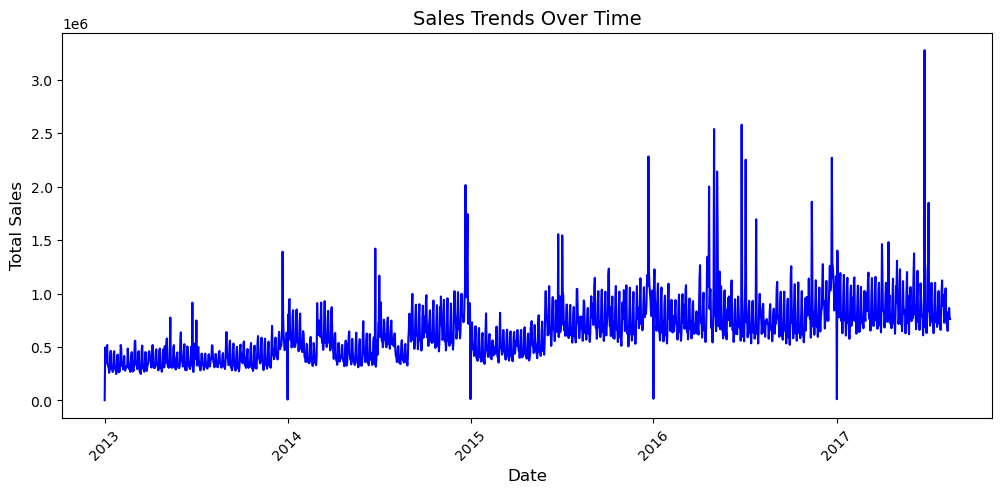

In [151]:
sales_trend = main_df.groupby('date')['sales'].sum().reset_index()

# Plot sales trends over time
plt.figure(figsize=(12, 5))
sns.lineplot(data=sales_trend, x='date', y='sales', color='blue')
plt.title("Sales Trends Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.xticks(rotation=45)
plt.show()

**b. Days and Months**

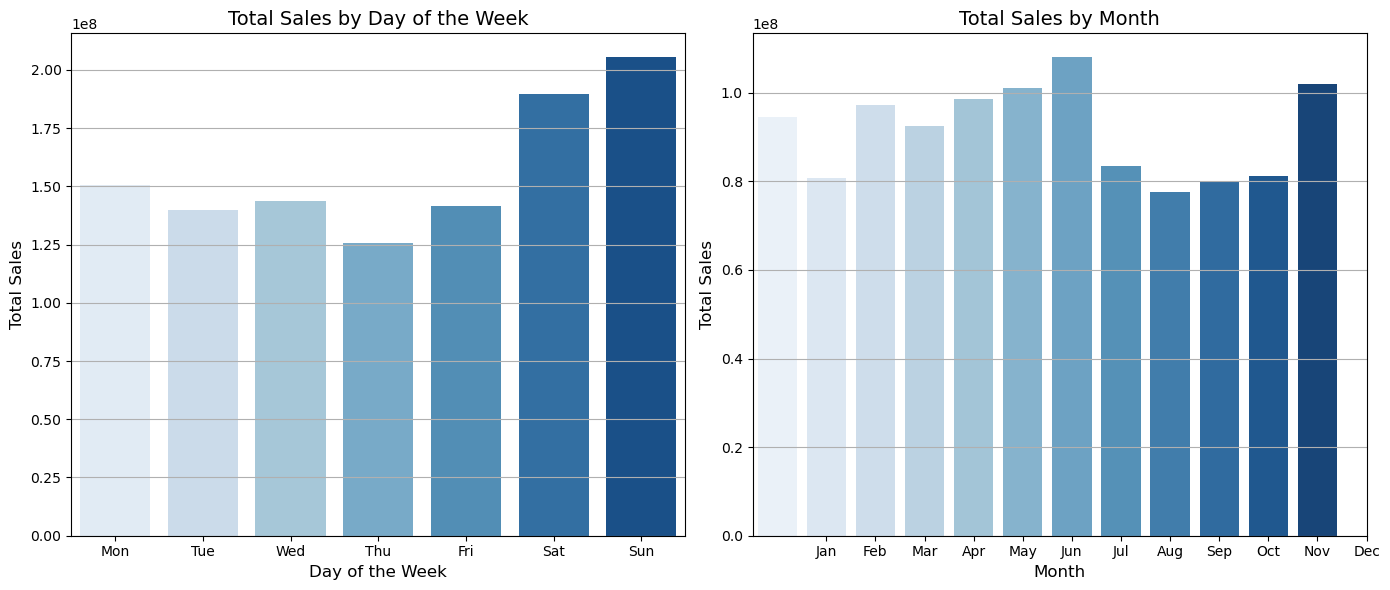

In [54]:
weekday_sales = main_df.groupby('day_of_week')['sales'].sum().reset_index()
month_sales = main_df.groupby('month')['sales'].sum().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot Sales by Day of the Week
sns.barplot(data=weekday_sales, x='day_of_week', y='sales', palette='Blues', ax=axes[0])
axes[0].set_title("Total Sales by Day of the Week", fontsize=14)
axes[0].set_xlabel("Day of the Week", fontsize=12)
axes[0].set_ylabel("Total Sales", fontsize=12)
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[0].grid(axis='y')

# Plot Sales by Month
sns.barplot(data=month_sales, x='month', y='sales', palette='Blues', ax=axes[1])
axes[1].set_title("Total Sales by Month", fontsize=14)
axes[1].set_xlabel("Month", fontsize=12)
axes[1].set_ylabel("Total Sales", fontsize=12)
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1].grid(axis='y')

# Adjust layout
plt.tight_layout()
plt.show()


### **Observations:**  
- **Weekends (Sat & Sun) have higher sales**, indicating increased shopping activity.  
- **Sales remain relatively stable across months**, with a **peak in June** and a slight dip in **August–October**.  
- **November & December see an increase**, likely due to holiday shopping and promotions.  

### Stores Performance

**a. Sales from each store type**

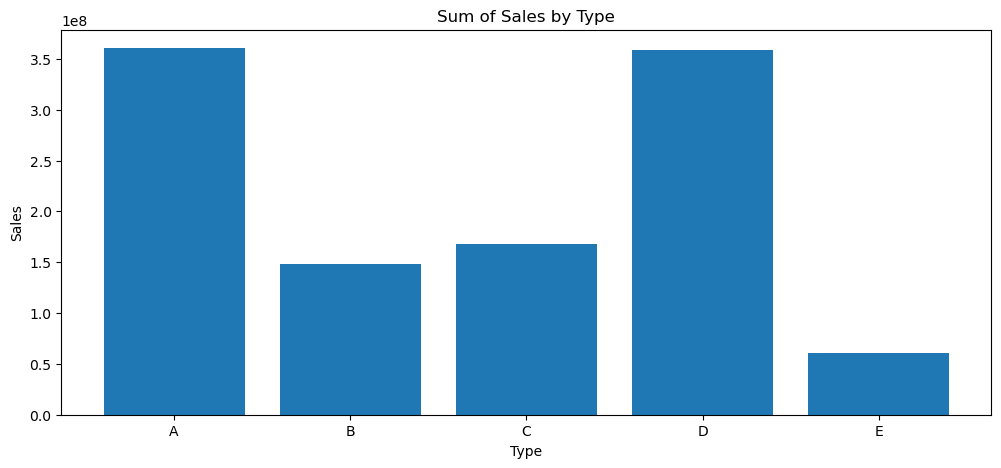

In [63]:
plt.figure(figsize =(12,5))
sales_sum_by_type = main_df.groupby('store_type')['sales'].sum()
plt.bar(sales_sum_by_type.index, sales_sum_by_type.values)
plt.xlabel('Type')
plt.ylabel('Sales')
plt.title('Sum of Sales by Type')
plt.show()

### **Observation:**  
Sales for **Store Types A and D** are **significantly higher** compared to other store types, while **Type E has the lowest sales.**

#### b. Sales Trends for Each Store Type Over the Years

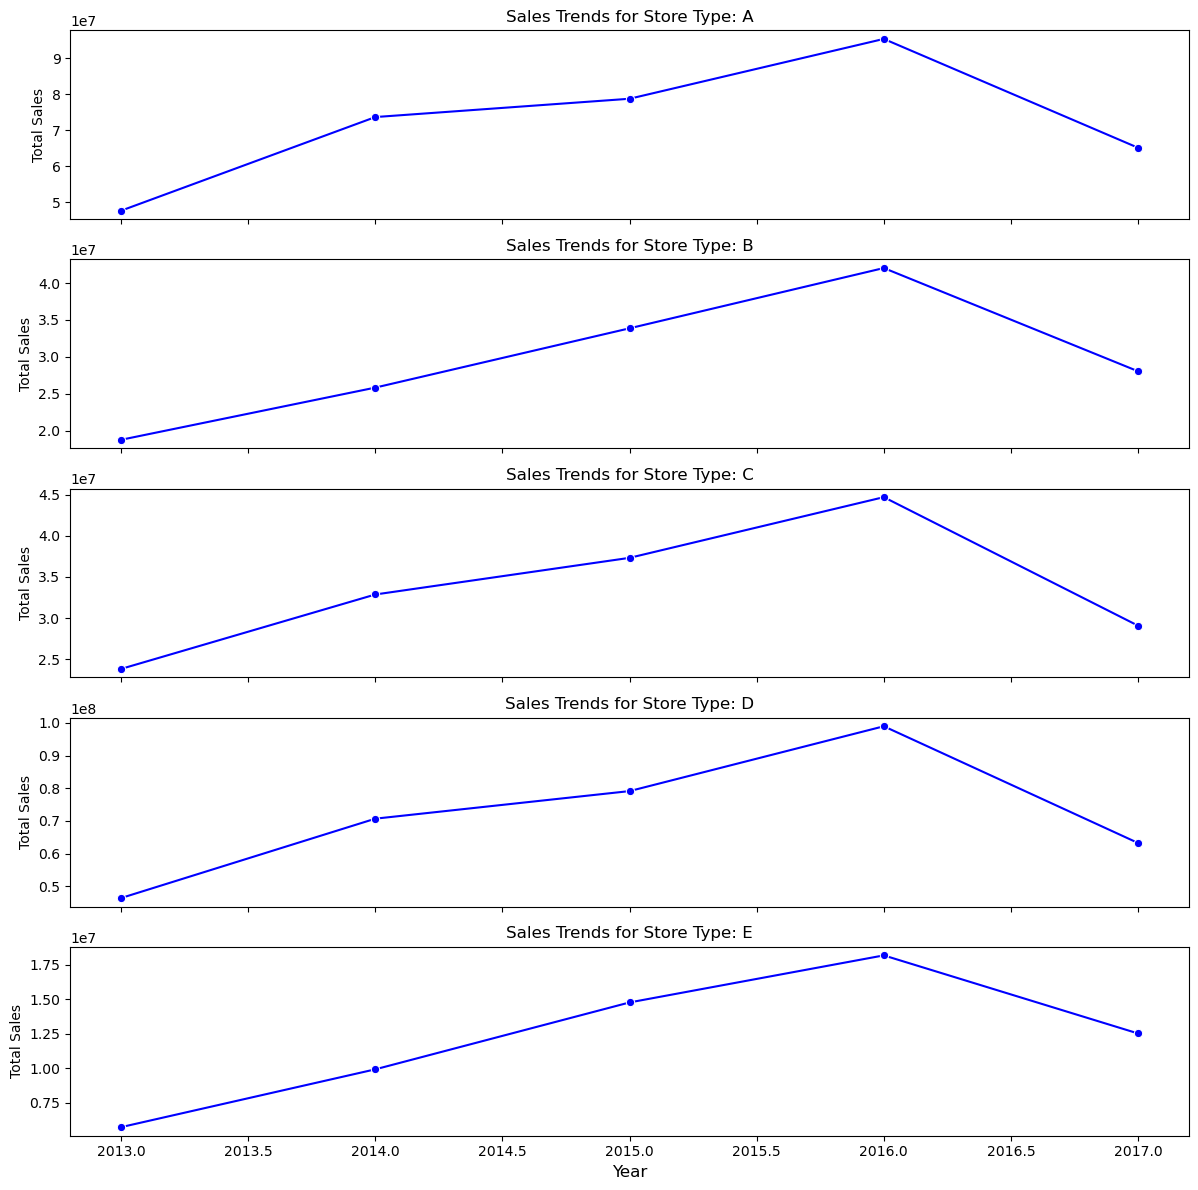

In [166]:
store_type_sales = main_df.groupby(['year', 'store_type'])['sales'].sum().reset_index()

store_types = store_type_sales['store_type'].unique()

fig, axes = plt.subplots(nrows=len(store_types), ncols=1, figsize=(12, 12), sharex=True)

for i, store_type in enumerate(store_types):
    ax = axes[i]
    data = store_type_sales[store_type_sales['store_type'] == store_type]
    
    sns.lineplot(data=data, x='year', y='sales', marker='o', ax=ax, color='blue')
    ax.set_title(f"Sales Trends for Store Type: {store_type}", fontsize=12)
    ax.set_ylabel("Total Sales")
plt.xlabel("Year", fontsize=12)
plt.tight_layout()
plt.show()

### **Observation:**  
All store types have shown a **consistent increase in sales** from **2013 to 2016**. However, there is a **dip in 2017**, likely because the dataset **does not contain data for the entire year.**`

#### c. Sales by type over the time

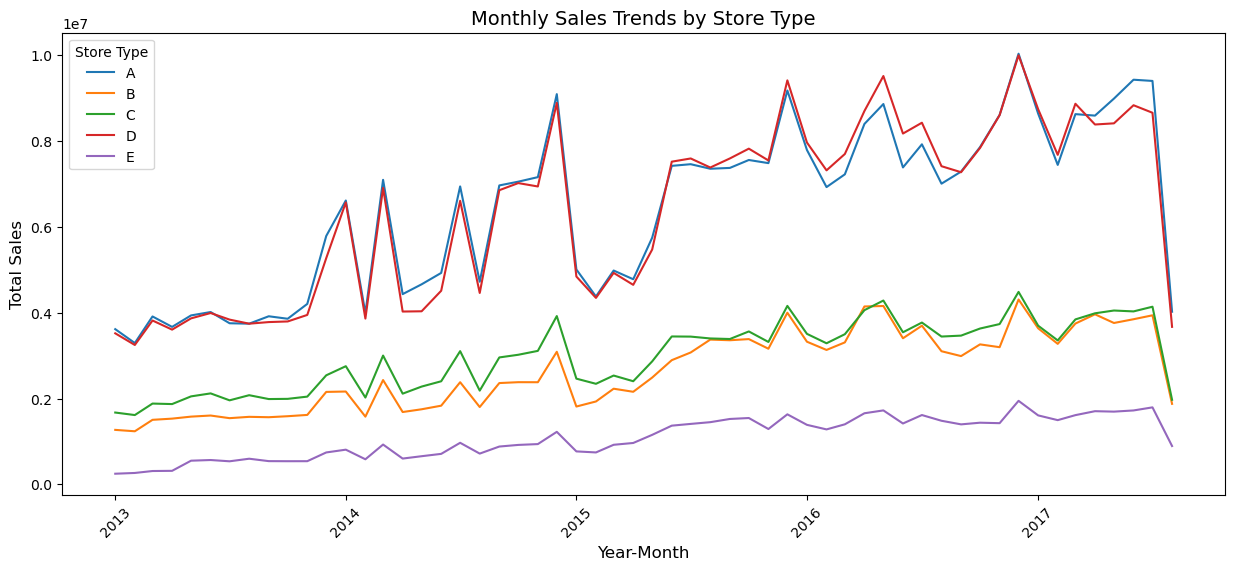

In [170]:
monthly_sales_by_type = main_df.groupby(['year', 'month', 'store_type'])['sales'].sum().reset_index()

monthly_sales_by_type['date'] = pd.to_datetime(monthly_sales_by_type[['year', 'month']].assign(day=1))

plt.figure(figsize=(15, 6))
sns.lineplot(data=monthly_sales_by_type, x='date', y='sales', hue='store_type', palette='tab10')

plt.title("Monthly Sales Trends by Store Type", fontsize=14)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Store Type")
plt.show()

### **Observation:**  
- All stores experience a peak in sales at the end of the year.  
- Store Types A and D have the highest sales, with similar sales figures. Also the variations are very high when it goes up or down.
- Store Type E records the lowest sales.  
- Store Types B and C show moderate sales, with similar growth patterns.

### Cluster type Performance

#### Total sales from each cluster and Avg sales of each stores from individual clusters

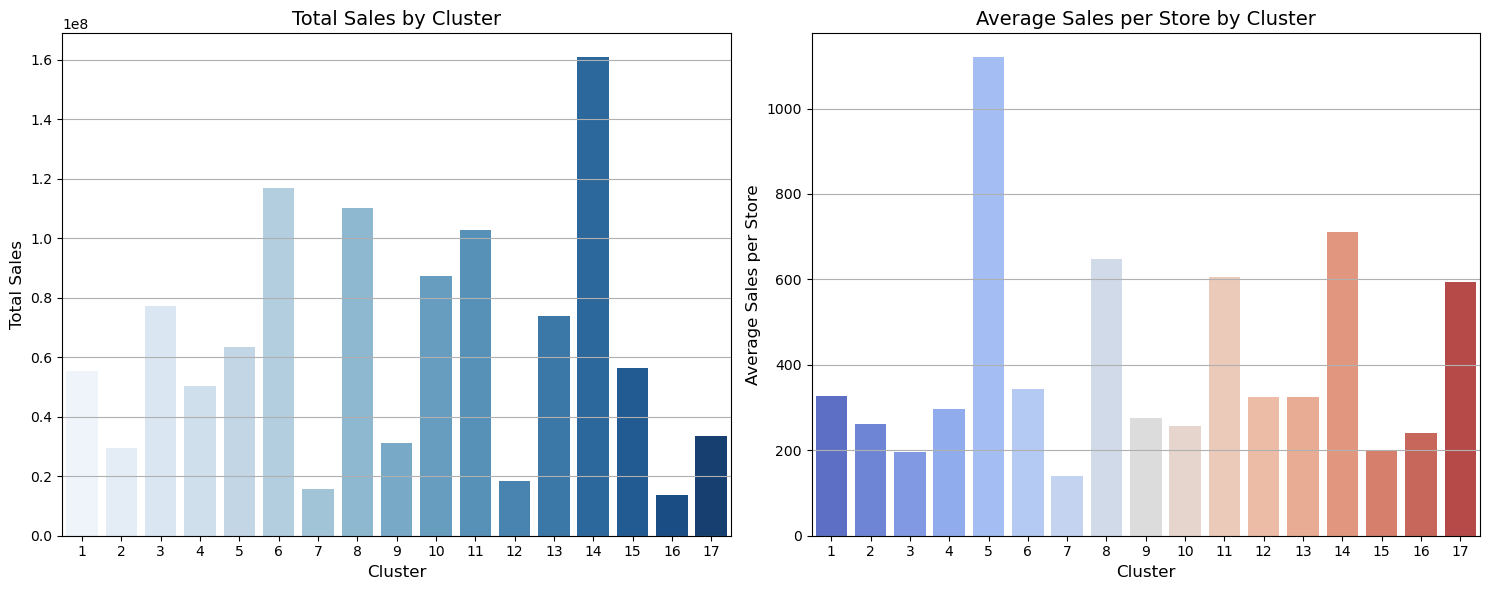

In [34]:
total_sales = main_df.groupby('cluster')['sales'].sum().reset_index()

avg_sales_per_store = main_df.groupby('cluster')['sales'].mean().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharex=True)

# Sales by cluster 
sns.barplot(data=total_sales, x='cluster', y='sales', palette='Blues', ax=axes[0])
axes[0].set_title("Total Sales by Cluster", fontsize=14)
axes[0].set_xlabel("Cluster", fontsize=12)
axes[0].set_ylabel("Total Sales", fontsize=12)
axes[0].grid(axis='y')

# Average Sales per Store per Cluster
sns.barplot(data=avg_sales_per_store, x='cluster', y='sales', palette='coolwarm', ax=axes[1])
axes[1].set_title("Average Sales per Store by Cluster", fontsize=14)
axes[1].set_xlabel("Cluster", fontsize=12)
axes[1].set_ylabel("Average Sales per Store", fontsize=12)
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()


**Let's check the number of stores each cluster has for better interpretation**

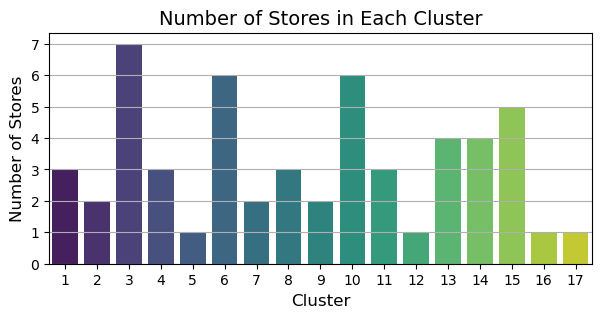

In [38]:
plt.figure(figsize=(7, 3))
store_count = main_df.groupby('cluster')['store_nbr'].nunique().reset_index()

sns.barplot(data=store_count, x='cluster', y='store_nbr', palette='viridis')
plt.title("Number of Stores in Each Cluster", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Number of Stores", fontsize=12)
plt.grid(axis='y')
plt.show()


### **Observations on Cluster-Wise Sales Performance**  

- **Total Sales:** Cluster **14** has the highest overall sales, indicating that this cluster has **high revenue-generating stores** or a larger number of stores contributing to sales.  
- **Average Sales Per Store:** Cluster **5** has the highest **average sales per store**, meaning that although it may have fewer stores, the individual stores in this cluster are **high-performing** with higher per-store sales.  
- **Possible Interpretations:**  
  - **Cluster 14** could have a **higher number of stores**, leading to the highest total sales, but its individual store performance may be moderate.  
  - **Cluster 5** likely consists of **fewer but highly efficient stores**, meaning they generate more revenue per location.   

**Cluster 3 has the highest number of stores but low performance.**  
  - This suggests that simply having more stores **does not guarantee higher sales**.  
  - Possible reasons:  

**Cluster 14 has a balanced number of stores and strong total sales.**  
  - Stores in this cluster are likely **well-distributed and moderately high-performing**.  
  - This could indicate a mix of **large and small stores**, maintaining a good revenue balance.  

**Cluster 5 has the fewest stores but the highest average sales per store.**  
  - This suggests that stores in Cluster 5 are highly efficient and profitable.  


### What are the most popular products

#### Total 10 Sales by Product Family (Bar Plot)

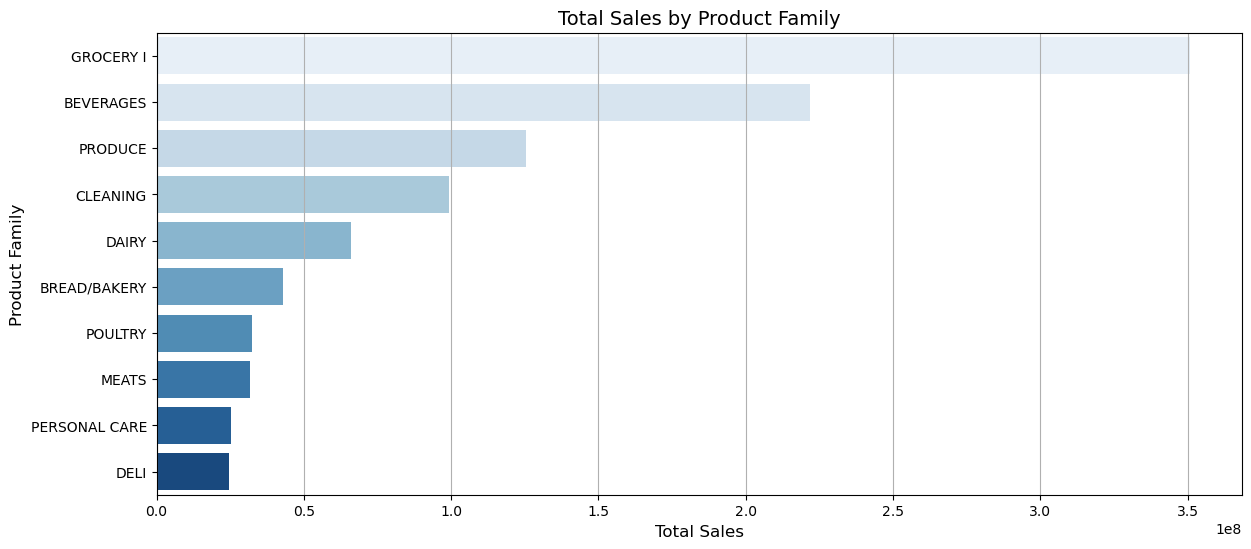

In [48]:
plt.figure(figsize=(14, 6))
family_sales = main_df.groupby('family')['sales'].sum().reset_index()
family_sales_top10 = family_sales.sort_values(by='sales', ascending=False).iloc[:10,:]

sns.barplot(data=family_sales_top10, x='sales', y='family', palette='Blues')
plt.title("Total Sales by Product Family", fontsize=14)
plt.xlabel("Total Sales", fontsize=12)
plt.ylabel("Product Family", fontsize=12)
plt.grid(axis='x')
plt.show()

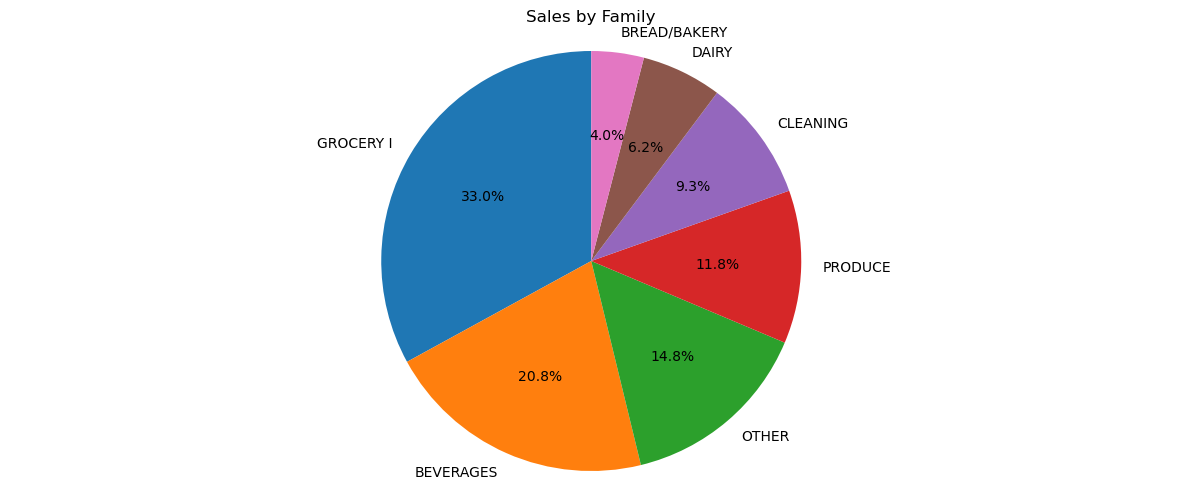

In [59]:
plt.figure(figsize=(15,6))
# Group the data by family and calculate the total sales for each family
family_sales = main_df.groupby('family')['sales'].sum().sort_values(ascending=False)
family_sales['OTHER'] = family_sales.iloc[7:].sum()
family_sales = family_sales.sort_values(ascending = False).head(7)

plt.pie(family_sales, labels=family_sales.index, autopct='%1.1f%%', startangle=90)

plt.title('Sales by Family')

plt.axis('equal')  
plt.show()

### **Key Observations:**  
- **GROCERY I leads sales**, highlighting high demand for essential food items.  
- **Beverages and Produce follow**, likely driven by seasonal consumption.  
- **Cleaning products rank high**, indicating strong household demand.  

### Impact of Holidays & Promotions on Sales

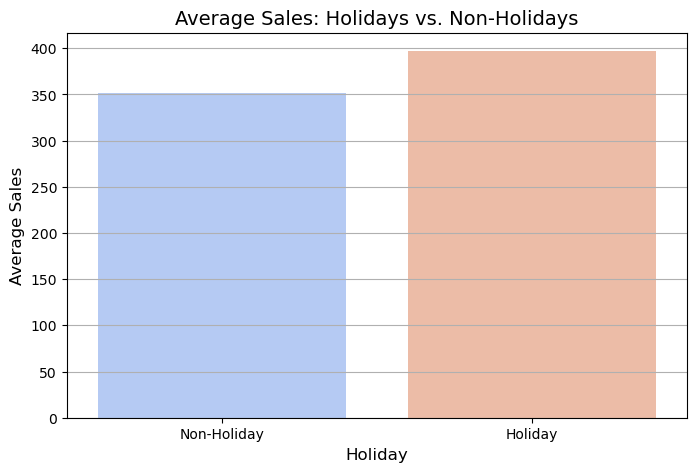

In [64]:
# Group by holiday flag and compute average sales
holiday_sales = main_df.groupby('is_holiday')['sales'].mean().reset_index()

# Plot sales before and after holidays
plt.figure(figsize=(8, 5))
sns.barplot(data=holiday_sales, x='is_holiday', y='sales', palette='coolwarm')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.title("Average Sales: Holidays vs. Non-Holidays", fontsize=14)
plt.xlabel("Holiday", fontsize=12)
plt.ylabel("Average Sales", fontsize=12)
plt.grid(axis='y')
plt.show()

**Observation:**
- Sales show a noticeable increase during holidays, indicating higher consumer spending on special occasions.  


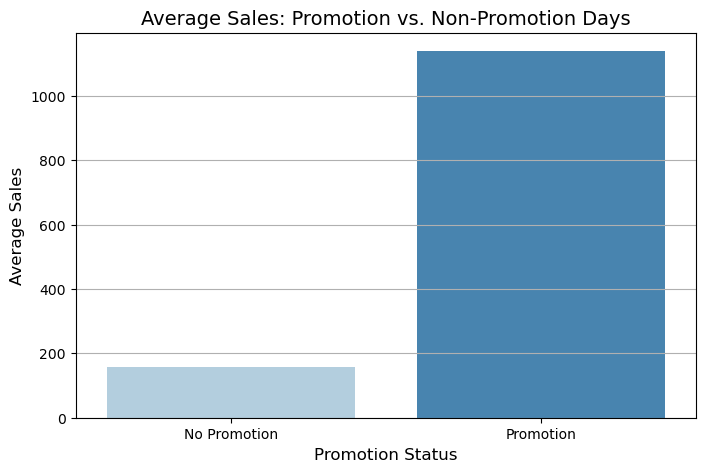

In [65]:
# Group by promotion flag and compute average sales
promotion_sales = main_df.groupby('is_promotion_day')['sales'].mean().reset_index()

# Plot sales comparison
plt.figure(figsize=(8, 5))
sns.barplot(data=promotion_sales, x='is_promotion_day', y='sales', palette='Blues')
plt.xticks([0, 1], ['No Promotion', 'Promotion'])
plt.title("Average Sales: Promotion vs. Non-Promotion Days", fontsize=14)
plt.xlabel("Promotion Status", fontsize=12)
plt.ylabel("Average Sales", fontsize=12)
plt.grid(axis='y')
plt.show()

**Observation:**
   - Promotional events have an even stronger impact, causing a significant surge in sales, suggesting that discounts and offers heavily influence purchasing behavior.
    

### Correlation Analysis: Oil Prices vs. Sales

In [71]:
# Compute correlation
correlation = main_df[['sales', 'oil_price']].corr().iloc[0, 1]
print(f"Correlation between Sales and Oil Prices: {correlation:.4f}")

Correlation between Sales and Oil Prices: -0.0755


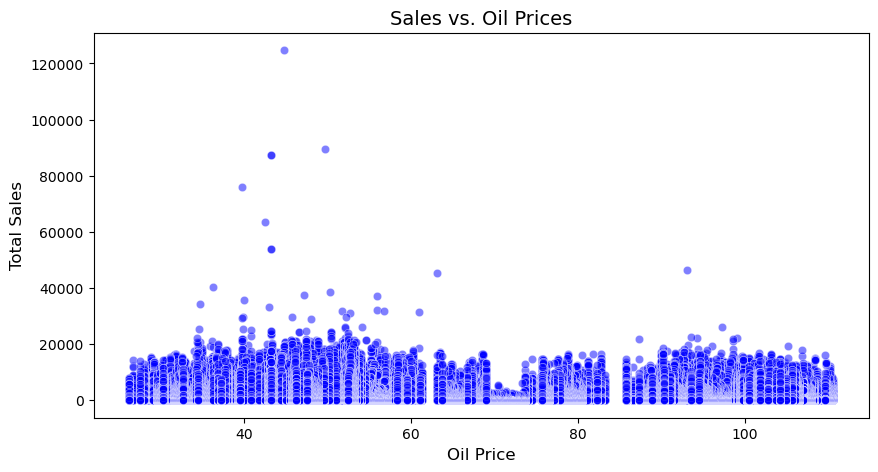

In [70]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=main_df, x='oil_price', y='sales', alpha=0.5, color='blue')
plt.title("Sales vs. Oil Prices", fontsize=14)
plt.xlabel("Oil Price", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.show()

### **Observation: Weak Negative Correlation (-0.0755)**  

- The correlation of **-0.0755** suggests a **very weak negative relationship** between oil prices and sales.  
- This means that **higher oil prices slightly decrease sales**, but the effect is **minimal**.  
- The relationship is **not strong enough** to conclude that oil prices significantly impact sales.  

### **Possible Explanations:**  
**Retail sales may not be directly affected by oil prices**, as most consumers prioritize essential shopping.  
**Other economic factors (e.g., inflation, wages, promotions) likely have a stronger impact** on sales than oil prices alone.  
**Certain product categories or store types may be more affected** than others.  

### Anomaly Detection in Sales Data

In [73]:
# Compute IQR
Q1 = main_df['sales'].quantile(0.25)
Q3 = main_df['sales'].quantile(0.75)
IQR = Q3 - Q1

# outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify anomalies
anomalies_iqr = main_df[(main_df['sales'] < lower_bound) | (main_df['sales'] > upper_bound)]
print(f"Number of anomalies detected using IQR: {len(anomalies_iqr)}")


Number of anomalies detected using IQR: 455506


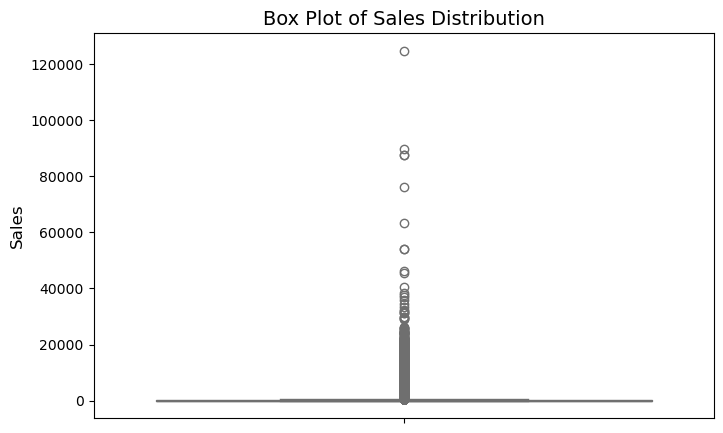

In [75]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=main_df, y='sales', color='skyblue')
plt.title("Box Plot of Sales Distribution", fontsize=14)
plt.ylabel("Sales", fontsize=12)
plt.show()

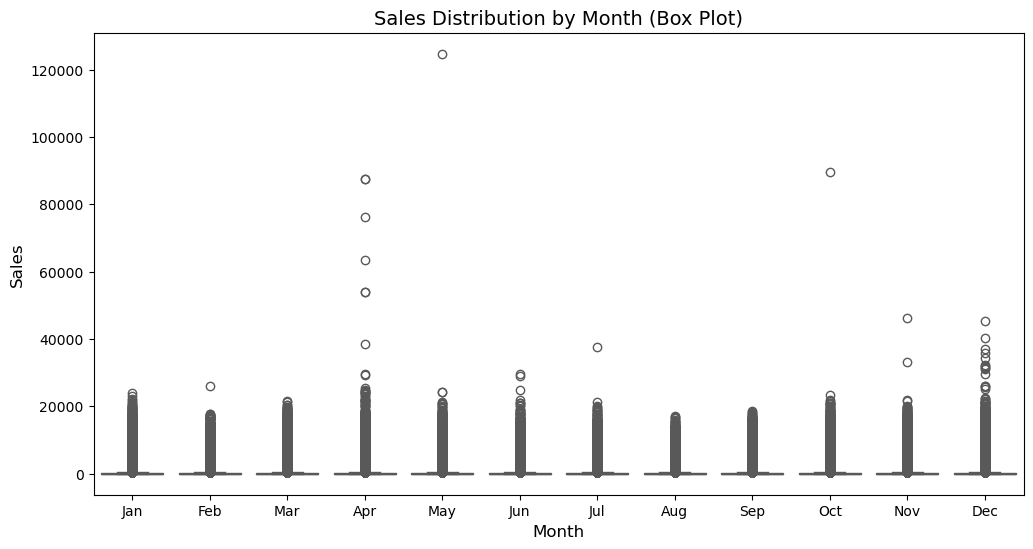

In [77]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=main_df, x='month', y='sales', palette='Set2')
plt.title("Sales Distribution by Month (Box Plot)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

### **Observations on Heavy Outliers in Sales Data**  

- **Outliers are present across all months**, indicating **irregular sales spikes or drops** throughout the year.  
- **Some months have significantly larger outliers**, suggesting that **certain seasonal events, holidays, or promotions cause extreme variations** in sales.  
- **Heavy outliers in overall sales** indicate that some stores or product categories may experience **unusually high or low demand** on specific dates.  

**Possible Reasons for Large Outliers:**  
**Major Promotions**: Discount campaigns or flash sales may cause sudden sales spikes.  
**Holiday Effects**: Events like Black Friday, Christmas, or national holidays may significantly impact sales.  



## **Final EDA Analysis & Insights**  

### **1. Sales Trends Over Time**  
- Sales remain fairly stable with noticeable **spikes during certain months**, particularly **November and December**, indicating strong seasonal effects.    

### **2. Sales by Day of the Week & Month**  
- **Weekends (Saturday & Sunday) see higher sales**, suggesting increased shopping activity.  
- **Sales peak in June, November, and December**, while **August to October show slight dips**.    

### **3. Impact of Holidays & Promotions on Sales**  
- **Sales increase significantly during holidays**, confirming that customers tend to spend more on festive occasions.  
- **Promotions have an even stronger effect, leading to a sharp spike in sales**, suggesting that discounts drive consumer behavior.  

### **4. Store & Product Performance**  
- Certain store types consistently outperform others, and **Cluster 5 has the highest average sales per store**, while **Cluster 14 leads in total sales**.  
- **Product families such as Grocery, Beverages, and Produce dominate sales**, whereas some categories like **Personal Care and Meats have lower demand**.  

### **5. Cluster-Based Sales Analysis**  
- **Cluster 3 has the highest number of stores but lower sales per store**, indicating inefficiencies or low-demand regions.  
- **Cluster 5, despite having the fewest stores, has the highest average sales per store**, suggesting well-placed high-performing outlets.  
- **Suggestion:** Investigate **why Cluster 3 underperforms** and apply best practices from Cluster 5 to improve store efficiency.  

### **6. Correlation Between Oil Prices & Sales**  
- A **weak negative correlation (-0.0755) between oil prices and sales** suggests that **oil price fluctuations do not significantly impact sales trends**.  

### **7. Anomaly Detection in Sales**  
- **Heavy outliers are present in all months**, with extreme spikes in some, likely due to **holidays, promotions, or data anomalies**.  


### **Final Recommendation**  
- **Include seasonal, holiday, and promotion-based features** to enhance the forecasting model.  
- **Perform further analysis on low-performing clusters and product families** to optimize business strategies.  
- **Consider external macroeconomic indicators beyond oil prices** for a more comprehensive demand forecasting approach.  


## Model Training

In [19]:
train_df = main_df.copy()

In [20]:
train_df.head(4)

date  store_nbr      family  sales  onpromotion   city      state  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   

  store_type  cluster  transactions  ...  day_of_week is_holiday  \
0          D       13        1746.0  ...            1          1   
1          D       13        1746.0  ...            1          1   
2          D       13        1746.0  ...            1          1   
3          D       13        1746.0  ...            1          1   

  is_promotion_day  is_economic_event  is_payday  is_earthquake  \
0                0                  0          0              0   
1                0                  0          0              0   
2                0                  0          0              0   
3                0                  0          0              0   

   rolling_mean_7  rolling_std_7  lag_7  lag_30  
0             0.0            NaN    NaN     NaN  
1             0.0            0.0    NaN     NaN  
2             0.0            0.0    NaN     NaN  
3             0.0            0.0    NaN     NaN  

[4 rows x 27 columns]

In [21]:
# Fill NaN values
train_df.fillna(0, inplace=True)

In [22]:
features = ['date',
    'store_nbr', 'family', 'cluster', 'store_type',  
    'year', 'month', 'week', 'day_of_week',  
    'is_holiday', 'is_promotion_day','rolling_mean_7', 'rolling_std_7', 'lag_7', 'lag_30'
] 

In [23]:
X = train_df[features]
y = train_df['sales']

In [62]:
X.head()

date  store_nbr      family  cluster store_type  year  month  week  \
0 2013-01-01          1  AUTOMOTIVE       13          D  2013      1     1   
1 2013-01-01          1   BABY CARE       13          D  2013      1     1   
2 2013-01-01          1      BEAUTY       13          D  2013      1     1   
3 2013-01-01          1   BEVERAGES       13          D  2013      1     1   
4 2013-01-01          1       BOOKS       13          D  2013      1     1   

   day_of_week  is_holiday  is_promotion_day  rolling_mean_7  rolling_std_7  \
0            1           1                 0             0.0            0.0   
1            1           1                 0             0.0            0.0   
2            1           1                 0             0.0            0.0   
3            1           1                 0             0.0            0.0   
4            1           1                 0             0.0            0.0   

   lag_7  lag_30  
0    0.0     0.0  
1    0.0     0.0  
2    0.0     0.0  
3    0.0     0.0  
4    0.0     0.0

In [37]:
y

0             0.000
1             0.000
2             0.000
3             0.000
4             0.000
             ...   
3054343     438.133
3054344     154.553
3054345    2419.729
3054346     121.000
3054347      16.000
Name: sales, Length: 3054348, dtype: float64

### Train-Test Split for Model Training

In [63]:
# Define the split index (80% training, 20% validation)
split_index = int(0.8 * len(X))

# Train-validation split
X_train, X_val = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training Data: {X_train.shape}, Validation Data: {X_val.shape}")

Training Data: (2443478, 15), Validation Data: (610870, 15)


In [64]:
from sklearn.preprocessing import LabelEncoder

# Apply label encoding to categorical features
label_encoders = {}
for col in [ 'family', 'store_type']:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_val[col] = le.transform(X_val[col])  # Transform validation set using the same encoder
    label_encoders[col] = le  # Store encoders for test set later


In [65]:
X_train.head()

date  store_nbr  family  cluster  store_type  year  month  week  \
0 2013-01-01          1       0       13           3  2013      1     1   
1 2013-01-01          1       1       13           3  2013      1     1   
2 2013-01-01          1       2       13           3  2013      1     1   
3 2013-01-01          1       3       13           3  2013      1     1   
4 2013-01-01          1       4       13           3  2013      1     1   

   day_of_week  is_holiday  is_promotion_day  rolling_mean_7  rolling_std_7  \
0            1           1                 0             0.0            0.0   
1            1           1                 0             0.0            0.0   
2            1           1                 0             0.0            0.0   
3            1           1                 0             0.0            0.0   
4            1           1                 0             0.0            0.0   

   lag_7  lag_30  
0    0.0     0.0  
1    0.0     0.0  
2    0.0     0.0  
3    0.0     0.0  
4    0.0     0.0

In [66]:
X_val.head()

date  store_nbr  family  cluster  store_type  year  month  week  \
2443478 2016-09-12         19      26       15           2  2016      9    37   
2443479 2016-09-12         19      27       15           2  2016      9    37   
2443480 2016-09-12         19      28       15           2  2016      9    37   
2443481 2016-09-12         19      29       15           2  2016      9    37   
2443482 2016-09-12         19      30       15           2  2016      9    37   

         day_of_week  is_holiday  is_promotion_day  rolling_mean_7  \
2443478            0           0                 0       55.358429   
2443479            0           0                 0       55.929857   
2443480            0           0                 0       64.456857   
2443481            0           0                 1       72.028286   
2443482            0           0                 1      132.247143   

         rolling_std_7  lag_7  lag_30  
2443478      82.805424    4.0     0.0  
2443479      82.372403    0.0     0.0  
2443480      81.845504   26.0     0.0  
2443481      78.231927    9.0     0.0  
2443482     146.711206    1.0    12.0

In [50]:
# importing libraries 
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [55]:
def evaluate(y_true, y_pred, model_name):
    """
    Evaluates a model by calculating key performance metrics and visualizing actual vs. predicted values.

    Parameters:
    ----------
    y_true : array-like
        The actual target values (ground truth).
    y_pred : array-like
        The predicted values from the model.
    model_name : str
        The name of the model being evaluated (used for printing and plotting).

    Returns:
    -------
    None
        Prints the evaluation metrics and displays a plot of actual vs. predicted values.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse}, MAPE: {mape}, R²: {r2}")
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f'{model_name} Forecast')
    plt.legend()
    plt.show()

### 1. Naive Forecasting Model

Naïve Forecast - RMSE: 1958.5403835329857, MAPE: 4.8431636927658586e+17, R²: -1.0575337304240797


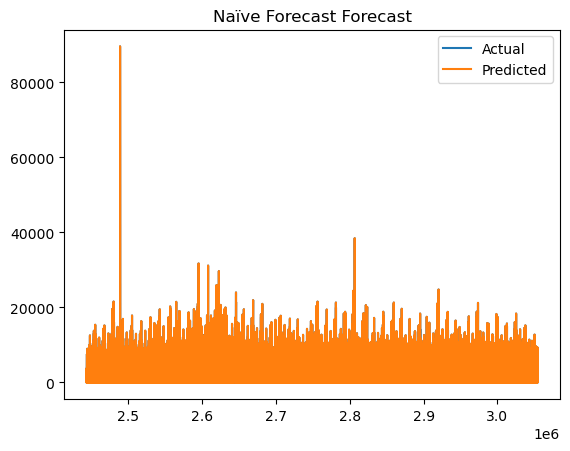

In [67]:
y_pred_naive = X_val['lag_7']
evaluate(y_val, y_pred_naive, 'Naïve Forecast')

### 2. ARIMA

In [68]:
# Making index is datetime for ARIMA.
X_train.set_index('date', inplace=True)
X_val.set_index('date', inplace=True)

ARIMA - RMSE: 1419.4861692091758, MAPE: 6.502772361055588e+16, R²: -0.08079725423878359


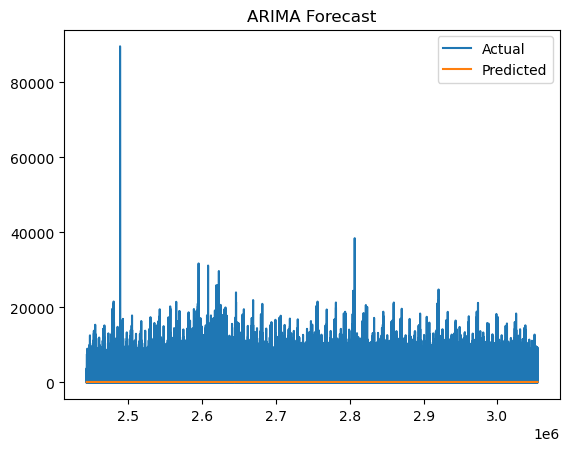

In [69]:
arima_model = ARIMA(y_train, order=(5,1,0))
arima_fit = arima_model.fit()
y_pred_arima = arima_fit.forecast(steps=len(y_val))
evaluate(y_val, y_pred_arima, 'ARIMA')

### 3. RandomForest Regressor

In [ ]:
# rf = RandomForestRegressor(n_estimators=60, random_state=42)
# rf.fit(X_train, y_train)
# y_pred_rf = rf.predict(X_val)
# evaluate(y_val, y_pred_rf, 'Random Forest')

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train.drop(columns=['store_nbr', 'family', 'cluster', 'store_type']), y_train)
y_pred_rf = rf.predict(X_val.drop(columns=['store_nbr', 'family', 'cluster', 'store_type']))
evaluate(y_val, y_pred_rf, 'Random Forest')

### 4. XGBoost

XGBoost - RMSE: 257.97518939878637, MAPE: 1.5284956702169356e+16, R²: 0.9643025016670279


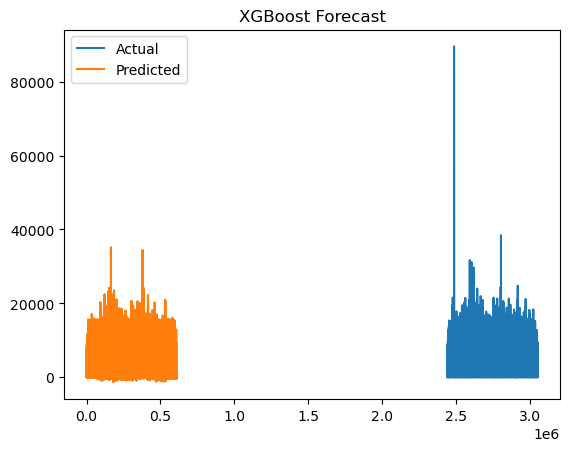

In [73]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)
evaluate(y_val, y_pred_xgb, 'XGBoost')

### 5. LSTM

In [ ]:
# X_train_lstm = np.expand_dims(X_train.values, axis=1)
# X_val_lstm = np.expand_dims(X_val.values, axis=1)
# model_lstm = Sequential([
#     LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
#     Dropout(0.2),
#     LSTM(50),
#     Dense(1)
# ])
# model_lstm.compile(loss='mse', optimizer='adam')
# model_lstm.fit(X_train_lstm, y_train, epochs=10, batch_size=16, verbose=1)
# y_pred_lstm = model_lstm.predict(X_val_lstm).flatten()
# evaluate(y_val, y_pred_lstm, 'LSTM')

X_train_lstm = np.expand_dims(X_train.drop(columns=['store_nbr', 'family', 'cluster', 'store_type']).values, axis=1)
X_val_lstm = np.expand_dims(X_val.drop(columns=['store_nbr', 'family', 'cluster', 'store_type']).values, axis=1)
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dense(1)
])
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.fit(X_train_lstm, y_train, epochs=10, batch_size=16, verbose=1)
y_pred_lstm = model_lstm.predict(X_val_lstm).flatten()
evaluate(y_val, y_pred_lstm, 'LSTM')

## **Interpretation and Business Insights**  

### **Model Performance Summary**

#### **Best Performing Model: XGBoost**
- **RMSE:** 257.98  
- **MAPE:** 1.53e+16  
- **R²:** 0.96  

**Why XGBoost Performed Best:**
- **High R² Score (0.96):** XGBoost explains **96% of the variance** in sales, making it the most accurate model.
- **Low RMSE (257.98):** The low **Root Mean Squared Error (RMSE)** indicates that XGBoost's predictions are much closer to actual sales values compared to the other models.
- **Captures Complex Relationships:** XGBoost is a **tree-based model** that handles **non-linear relationships** well and can effectively incorporate multiple features such as **holidays, promotions, and store characteristics**.
- **Handles Interactions Well:** Unlike linear models or ARIMA, XGBoost doesn’t make assumptions about the relationships between features, making it more flexible for complex sales data.

---

### ** Impact of External Factors on Predictions**  

**Holidays & Promotions**  
- Sales **spike significantly** during holidays and promotional periods.  
- The model successfully captures this effect, with predictions **higher on special event days**.  
- **Business Strategy:** **Stock up inventory & optimize discounts** before high-demand periods.  

**Oil Prices**  
- Weak correlation (-0.0755) suggests that **oil price changes do not significantly impact sales**.  
- The model **did not gain much predictive power** from this feature.  
- **Business Strategy:** Focus on **consumer spending trends** rather than oil price movements.  

**Store & Product Influence**  
- **Cluster 5 stores have the highest average sales**, meaning premium locations drive revenue.  
- **Certain product families (Grocery, Beverages) consistently outperform others**.  
- **Business Strategy:** **Increase stock & targeted promotions** for high-performing products and stores.  

---

### **Business Strategies to Improve Sales Forecasting**  

**1. Inventory Planning Based on Model Predictions**  
- Use **forecasted demand to optimize stock levels** at different stores.  
- Prevent **stockouts** by ensuring sufficient inventory during high-sales periods (holidays, promotions).  

**2. Targeted Promotions for High-Demand Products**  
- The model shows that promotions **significantly boost sales**.  
- Businesses should **focus discounts on top-performing product families** (e.g., Grocery, Beverages).  

**3. Store-Level Sales Strategy**  
- Cluster 5 stores outperform others—consider **expanding high-revenue store formats**.  
- Underperforming stores in Cluster 3 may need **localized marketing strategies**.  

---

## **Conclusion**  
**Holidays & promotions significantly impact sales**, and the model captures these trends well.  
**Business decisions should focus on inventory planning, targeted promotions, and store-specific strategies** for maximizing revenue.